# **Testando o modelo do Detector de Emoções**

# **Etapa 1 - Importando as bibliotecas**

In [91]:
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
import zipfile
%tensorflow_version 2.x
import tensorflow
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
tensorflow.__version__

'2.3.0'

# **Etapa 2 - Conectando com o Drive e acessando os arquivos**

Faça o download dos arquivos necessários aqui: https://drive.google.com/file/d/1JGhlcmLLnVO44uF8DdNvCMYt-gOr3iI2/view?usp=sharing

Importe para o seu google drive. No meu caso eu importei para /Colab/Material.zip no meu Gdrive, caso faça upload para pasta diferente, lembre-se de alterar o caminho da descompactação no código abaixo.

É recomendavel importar para o Gdrive, pois dessa forma reduz o tempo de upload para o Colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = "/content/gdrive/My Drive/Colab/Material.zip"
zip_object = zipfile.ZipFile(file = path, mode = "r")
zip_object.extractall('./')
zip_object.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/gdrive/My Drive/Colab/Material.zip' mode='r'>>

# **Testar com foto capturada da webcam**

**Carregar biblioteca e função**

In [92]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image
 
VIDEO_HTML = """
<style>
.animate
{
    transition: all 0.1s;
    -webkit-transition: all 0.1s;
}
 
.action-button
{
    position: relative;
    padding: 10px 40px;
  margin: 0px 10px 10px 0px;
  float: right;
    border-radius: 3px;
    font-family: 'Lato', sans-serif;
    font-size: 18px;
    color: #FFF;
    text-decoration: none;  
}
 
.blue
{
    background-color: #3498db;
    border-bottom: 5px solid #2980B9;
    text-shadow: 0px -2px #2980B9;
}
.action-button:active
{
    transform: translate(0px,5px);
  -webkit-transform: translate(0px,5px);
    border-bottom: 1px solid;
}
.bloco{
  width:400px;
  background-color: black;
}
.txt{color:white;}
#espelho
{
    transform: rotateY(180deg);
    -webkit-transform:rotateY(180deg); /* Safari and Chrome */
    -moz-transform:rotateY(180deg); /* Firefox */
}
</style>
<div class="bloco">
<h1 class="txt">Detector de Emoções</h1>
<video id="espelho" autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<button type="button" class="action-button shadow animate blue">Tirar Foto</button>
</div>
<script>
 
var video = document.querySelector('video')
var botao = document.querySelector('button')
 
navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  botao.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d').scale(-1, 1);
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w*-1, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def tirar_foto(filename='photo.jpg', quality=100, size=(400,300)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))

**Capturando a foto**

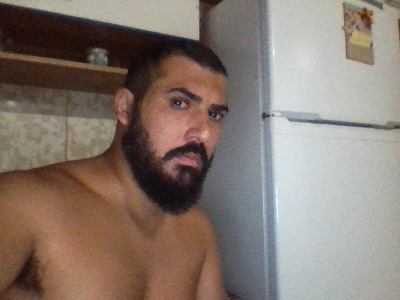

True

In [167]:
# Clique na imagem da webcam para tirar uma foto
imagem = tirar_foto() 
# Inverte a ordem dos canais (utilizar caso a imagem capturada fique com cores invertidas)
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB) 
#imagem = cv2.flip(imagem,1) ~ espelha a imagem. Como no js já estou espelhando, descomente para ver o resultado real da img
cv2_imshow(imagem)
cv2.imwrite("testecaptura.jpg",imagem)

In [169]:
cascade_faces = 'Material/haarcascade_frontalface_default.xml'
caminho_modelo = 'Material/modelo_01_expressoes.h5'
face_detection = cv2.CascadeClassifier(cascade_faces)
classificador_emocoes = load_model(caminho_modelo, compile=False)

[0.43475685 0.0829412  0.2453675  0.0170401  0.14265753 0.0278192
 0.04941766]


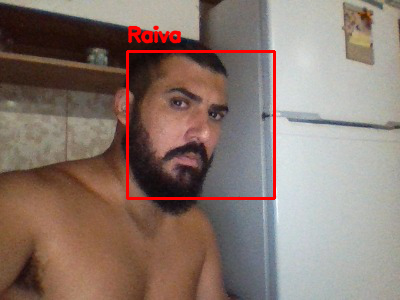

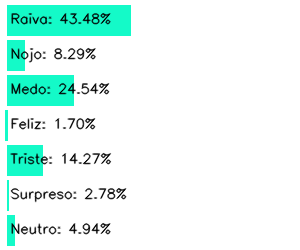

In [170]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
 
# Carrega o modelo
face_detection = cv2.CascadeClassifier(cascade_faces)
classificador_emocoes = load_model(caminho_modelo, compile=False)
 
expressoes = ["Raiva", "Nojo", "Medo", "Feliz", "Triste", "Surpreso", "Neutro"]
 
original = imagem.copy()
faces = face_detection.detectMultiScale(original,scaleFactor=1.1,minNeighbors=3,minSize=(20,20))
cinza = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
 
if len(faces) > 0:
    for (fX, fY, fW, fH) in faces:
      roi = cinza[fY:fY + fH, fX:fX + fW]
      roi = cv2.resize(roi, (48, 48))
      roi = roi.astype("float") / 255.0
      roi = img_to_array(roi)
      roi = np.expand_dims(roi, axis=0)
      preds = classificador_emocoes.predict(roi)[0]
      print(preds)
      emotion_probability = np.max(preds)
      label = expressoes[preds.argmax()]
      cv2.putText(original, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2, cv2.LINE_AA)
      cv2.rectangle(original, (fX, fY), (fX + fW, fY + fH),(0, 0, 255), 2)
else:
    print('Nenhuma face detectada')
 
 
cv2_imshow(original)
 
probabilidades = np.ones((250, 300, 3), dtype="uint8") * 255
# Mostra gráfico apenas se detectou uma face
if len(faces) == 1:
  for (i, (emotion, prob)) in enumerate(zip(expressoes, preds)):
      # Nome das emoções
      text = "{}: {:.2f}%".format(emotion, prob * 100)
      w = int(prob * 300)
      cv2.rectangle(probabilidades, (7, (i * 35) + 5),
      (w, (i * 35) + 35), (200, 250, 20), -1)
      cv2.putText(probabilidades, text, (10, (i * 35) + 23),
      cv2.FONT_HERSHEY_SIMPLEX, 0.45,
      (0, 0, 0), 1, cv2.LINE_AA)
 
  cv2_imshow(probabilidades)
 
cv2.imwrite("captura.jpg",original)
cv2.destroyAllWindows()